In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fft import fft, fftfreq
import os
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 適用於 Windows
plt.rcParams['axes.unicode_minus'] = False  # 避免負號變成方塊
# 讀取 WAV 檔案
wav_path = "2025-02-25T105155.wav"
sample_rate, data = wav.read(wav_path)

# 若為雙聲道，取一聲道
if data.ndim > 1:
    data = data[:, 0]

# 計算 FFT
N = len(data)
T = 1.0 / sample_rate
yf = fft(data)
xf = fftfreq(N, T)[:N // 2]  # 只取正頻率部分


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fft import fft, fftfreq
import os

def get_frequency_dependent_attenuation(xf: np.ndarray, depth_m: float) -> np.ndarray:
    """依頻率回傳衰減倍率（線性尺度）"""
    attenuation = np.ones_like(xf)

    # 100–300 Hz → 衰減小
    low_mask = (xf >= 100) & (xf <= 300)
    attenuation[low_mask] = 10 ** (-0.5 * depth_m / 20)

    # 500–700 Hz → 衰減大
    high_mask = (xf >= 500) & (xf <= 700)
    attenuation[high_mask] = 10 ** (-8.0 * depth_m / 20)

    # 其他頻段 → 使用預設衰減值（例如 4.9 dB/m）
    other_mask = ~(low_mask | high_mask)
    attenuation[other_mask] = 10 ** (-4.901 * depth_m / 20)

    return attenuation

def simulate_fft_with_attenuation_and_noise(
    wav_path: str,
    depths_mm: list = [0, 200, 400, 600, 1000],
    noise_band: tuple = (400, 600),
    noise_ratio: float = 0.15,
    add_wind_noise: bool = True,
    max_freq: int = 1200,
    save_path: str = None
):
    """模擬 FFT 衰減並可選擇加入風切聲雜訊"""

    # 自動命名儲存檔案
    if save_path is None:
        suffix = "wind" if add_wind_noise else "nowind"
        base_name = os.path.splitext(os.path.basename(wav_path))[0]
        save_path = f"{base_name}_attenuated_spectra_{suffix}.png"

    # 讀取音訊
    sample_rate, data = wav.read(wav_path)
    if data.ndim > 1:
        data = data[:, 0]
    N = len(data)
    T = 1.0 / sample_rate
    yf = fft(data)
    xf = fftfreq(N, T)[:N // 2]
    amplitude = 2.0 / N * np.abs(yf[:N // 2])

    # 限制頻率
    mask = xf <= max_freq
    xf_limited = xf[mask]
    amplitude_limited = amplitude[mask]

    # 計算雜訊區間遮罩 & 強度
    freq_mask = (xf_limited >= noise_band[0]) & (xf_limited <= noise_band[1])
    noise_level = noise_ratio * np.max(amplitude_limited[freq_mask])

    # 每層深度處理
    spectra_list = []
    for depth_mm in depths_mm:
        depth_m = depth_mm / 1000
        freq_attn = get_frequency_dependent_attenuation(xf_limited, depth_m)
        spectrum = amplitude_limited * freq_attn

        if add_wind_noise:
            noise = np.random.normal(0, noise_level, size=np.sum(freq_mask))
            spectrum[freq_mask] += noise

        spectra_list.append(spectrum)

    # 繪圖
    plt.rcParams['axes.unicode_minus'] = False
    fig, axs = plt.subplots(len(depths_mm), 1, figsize=(12, 12), sharex=True)

    for i, spectrum in enumerate(spectra_list):
        axs[i].plot(xf_limited, spectrum, label=f"{depths_mm[i]} mm", color="tab:blue")
        axs[i].set_ylabel("振幅")
        axs[i].set_ylim(0, 210)
        axs[i].legend(loc="upper right")
        axs[i].grid(True)

    axs[-1].set_xlabel("頻率 (Hz)")
    fig.suptitle(f"各深度下的 FFT 頻譜 {wav_path}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(save_path, dpi=300)
    plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_35552\1492497694.py:87: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\User\AppData\Local\Temp\ipykernel_35552\1492497694.py:87: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\User\AppData\Local\Temp\ipykernel_35552\1492497694.py:87: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\User\AppData\Local\Temp\ipykernel_35552\1492497694.py:87: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\User\AppData\Local\Temp\ipykernel_35552\1492497694.py:87: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\User\AppData\Local\Temp\ip

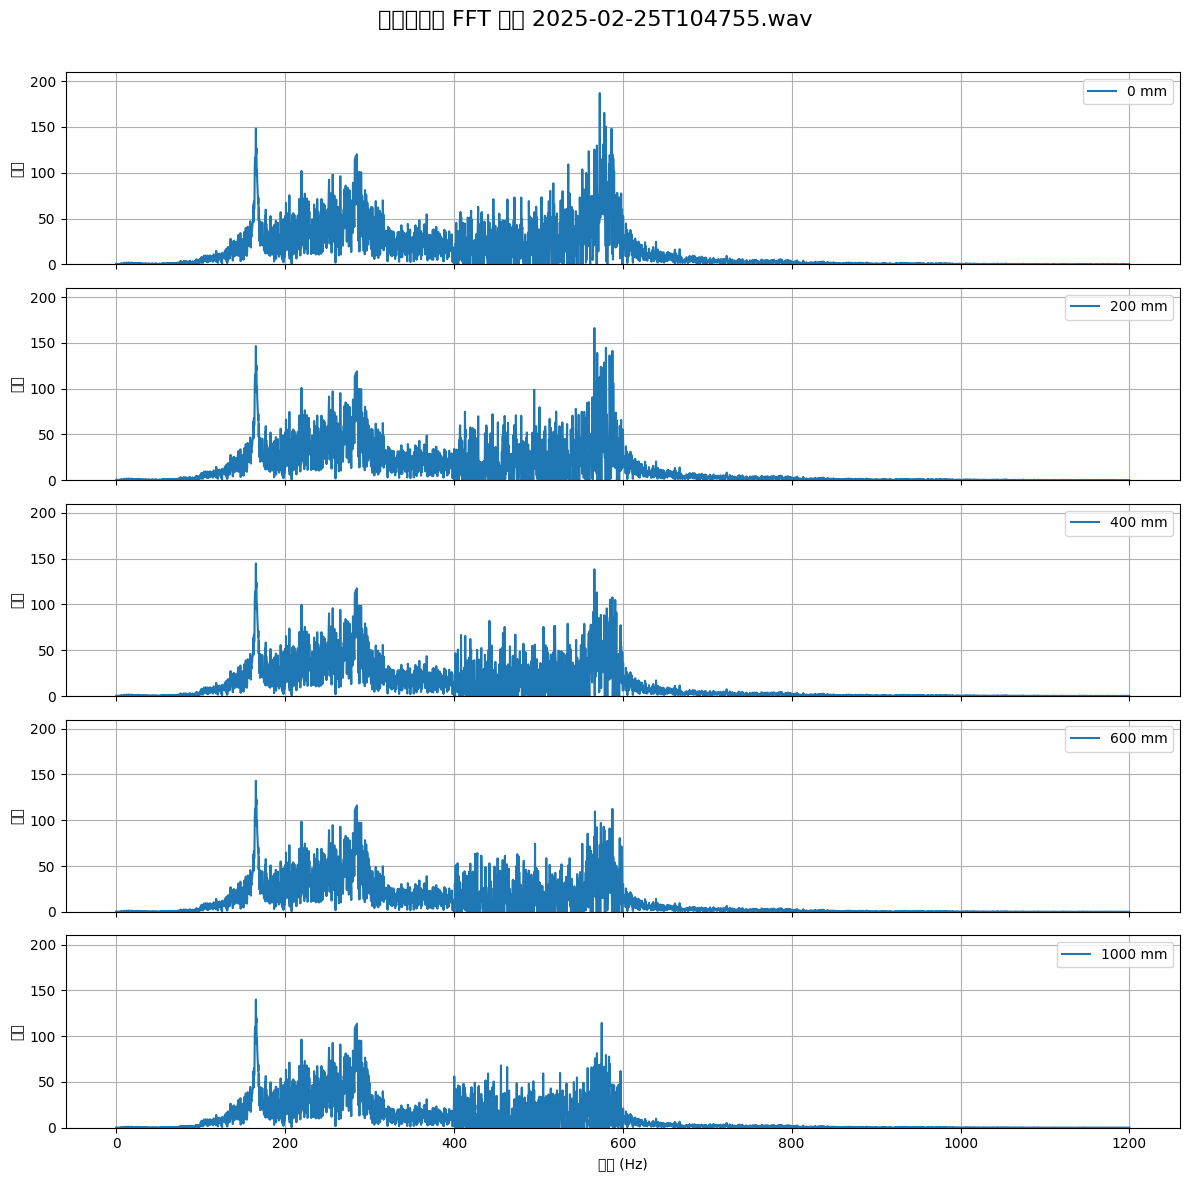

In [26]:
simulate_fft_with_attenuation_and_noise(
    wav_path="2025-02-25T104755.wav",
    add_wind_noise=True  # 或 False，不加入風切聲
)


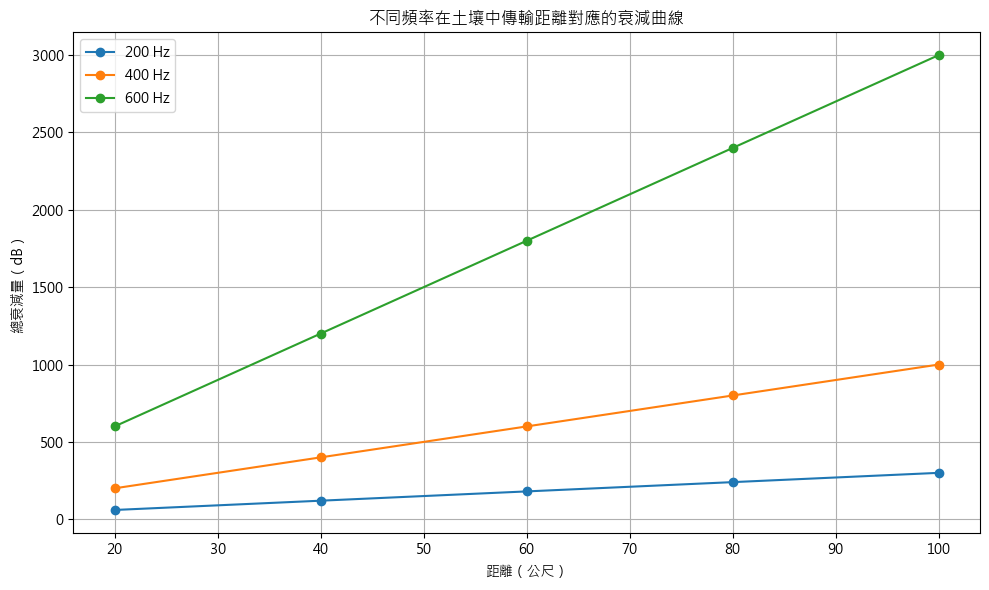

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 定義距離（公尺）
distances = np.array([20, 40, 60, 80, 100])

# 預設的三種頻率對應的衰減係數 (dB/m)，以下為估算值：
attenuation_200Hz = 3   # dB/m，低頻衰減較小
attenuation_400Hz = 10  # dB/m，中等衰減
attenuation_600Hz = 30  # dB/m，高頻衰減較大

# 計算不同頻率下的總衰減 (dB) = 每公尺衰減 * 距離
atten_200 = attenuation_200Hz * distances
atten_400 = attenuation_400Hz * distances
atten_600 = attenuation_600Hz * distances

# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(distances, atten_200, label='200 Hz', marker='o')
plt.plot(distances, atten_400, label='400 Hz', marker='o')
plt.plot(distances, atten_600, label='600 Hz', marker='o')
plt.title("不同頻率在土壤中傳輸距離對應的衰減曲線")
plt.xlabel("距離（公尺）")
plt.ylabel("總衰減量（dB）")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
